# Tesis de Licenciatura en Astronomía

## Manuel López Vargas

# Detección de señales en series de tiempo astronómicas utilizando algoritmos de Machine Learning

In [435]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as signal
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast

In [436]:
rng = np.random.default_rng()

In [451]:
A = 3
B = 3
C = 2
w1 = 3.28 #rad/sec
w2 = 2.3 #rad/sec
w3 = 1.3 #rad/sec
psi1 = 1. #rad
psi2 = 1.8 #rad
n_in = 150
n_out = 10000

Generamos aleatoriamente tiempos de muestreo.

In [452]:
t = rng.uniform(0, 10*np.pi, n_in)

Ploteamos dos ondas sinusoidales con freciencias diferentes ($\frac{w1}{w2}\neq Q$) para los tiempos seleccionados.

In [453]:
x = A * np.sin(w1*t + psi1) + B * np.sin(w2*t + psi2) 

Definimos un arreglo de frecuencias para el que se calculará el periodograma

In [454]:
w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

Calculo el Lomb-Scargle periodograma

In [455]:
pgram = signal.lombscargle(t, x, w, normalize=True)

Ploteo los datos de salida

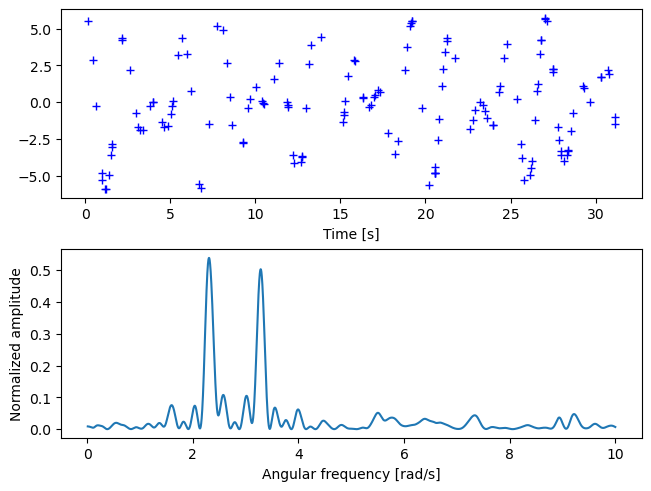

In [456]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

Los resultados no cambian cuando $(\frac{w1}{w2}= Q)$

Probamos con otro código.

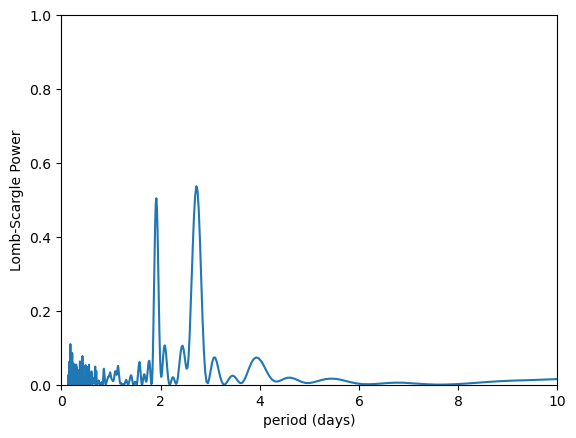

In [457]:
model = LombScargleFast().fit(t, x)
periods, power = model.periodogram_auto(nyquist_factor)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1.0),
        xlabel='period (days)',
        ylabel='Lomb-Scargle Power');

In [458]:
# seteamos el rango y encontramos el periodo

model.optimizer.period_range=(1,10)
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:', nu, period)

Finding optimal frequency:
 - Estimated peak width = 0.203
 - Using 5 steps per peak; omega_step = 0.0405
 - User-specified period range:  1 to 10
 - Computing periods at 141 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
La frecuencia encontrada es: 2.304599116398395 2.726368010154793


#### Calculamos la False-Alarm Probablility (FAP).

La FAP se define como FAP(z) = $1 - [P_{single0}(z)]^{N_{eff.}}$ donde $N_{eff.}= f_{max}T$

Utilizando la libreria astropy.timeseries vamos a calcular la FAP.

In [461]:
ls = LombScargle(t, x, normalization='standard')
power = ls.power(w)
print(power.max())  

0.5377375143699817


In [465]:
fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

FAP = 8.624718172014559e-22


Lo que esto nos dice es que, suponiendo que no haya una señal periódica en los datos, observaremos un pico tan alto o más con una probabilidad de $1.005\ e^{-19}$, lo que nos da una fuerte indicación de que hay una señal periódica presente en los datos.

In [464]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.11994045, 0.12901038, 0.14908504])

Esto nos indica que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,119; para el 5%, 0,129, y para el 1%, 0,149.

### Ahora simularemos nuestros datos utilizando un potencial con simetria esférica.

Probamos primero con el siguiente potencial:

### $\phi(r) = \frac{GM}{r} $

Luego

### $\ddot{x} = - \nabla \phi(r)$

Podemos descomponer esta ecuación diferencial de segundo orden en dos ecuaciones de primer orden.

### $\dot{x} = v\ \ \ ,\ \ \dot{x}(0) = \dot{x}_0$
### $\dot{v} = -\nabla \phi\ \ \ , \ \ x(0) = x_0$